In [1]:
import os
from tqdm import tqdm
import math
import numpy as np
import pandas as pd

from sklearn.metrics import roc_curve, auc, average_precision_score, roc_auc_score
from scipy import stats

from src.utils import parse_filename, normalize, sliding_window

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model

from xstream.python.Chains import Chains

import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{libertine}'
mpl.rc('font', family='serif')

In [2]:
data_name = "synth"

if data_name == "xdk" or data_name == "MHEALTHDATASET" or "pmsm_temperature_data":
    data = []
    directory = os.path.join(os.getcwd(), "data", data_name)
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".csv"):
                print("Read {}".format(file))
                data.append(np.loadtxt(os.path.join(directory, file), skiprows=1, delimiter=","))
    data = np.array(data)
if data_name == "synth":
    data = np.load(os.path.join(os.getcwd(), "data", "synth", "10_10000_100_0.2_0.2_0.01_0.4_0.2_local_d.npy"))
    
print("Executing on {} data".format(data_name))

Executing on synth data


In [3]:
min_length = min([len(d) for d in data])
max_length = 10000
indices = np.random.choice(np.arange(min_length), min(min_length, max_length))
trimmed_data = np.array([d[indices] for d in data])

In [4]:
contamination = 0.01
percentile = (1-contamination)*100
percentile

99.0

In [5]:
k = 50
nchains = 50
depth = 10

In [6]:
oldshape = trimmed_data.shape
trimmed_data = np.reshape(trimmed_data, newshape=(trimmed_data.shape[0]*trimmed_data.shape[1], trimmed_data.shape[2]))
cf = Chains(k=k, nchains=nchains, depth=depth)
cf.fit(trimmed_data)
predictions = -cf.score(trimmed_data)
predictions = np.reshape(predictions, newshape=(oldshape[0], oldshape[1]))
trimmed_data = np.reshape(trimmed_data, newshape=oldshape)

Scoring...: 100%|██████████| 50/50 [07:08<00:00,  8.57s/it]


In [7]:
predictions_global = predictions.flatten()

In [8]:
predictions.shape

(10, 10000)

In [9]:
models = [Chains(k=k, nchains=nchains, depth=depth) for _ in range(len(data))]
_ = [model.fit(trimmed_data[i]) for i, model in enumerate(models)]
predictions_local = np.array([-model.score(trimmed_data[i]) for i, model in enumerate(models)])

Scoring...: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


In [10]:
predictions_local = np.reshape(predictions_local, newshape=(trimmed_data.shape[0], trimmed_data.shape[1]))

In [11]:
result_local = predictions_local
result_global = predictions_global

In [12]:
outlier_thresh_local = np.percentile(result_local, percentile, axis=1, keepdims=True)
outlier_thresh_local = np.repeat(outlier_thresh_local, result_local.shape[-1], axis=-1)
labels_local = (result_local > outlier_thresh_local).flatten()
outlier_thresh_local.shape

(10, 10000)

In [13]:
outlier_thresh_global = np.percentile(result_global, q=percentile)
labels_global = (result_global > outlier_thresh_global).flatten()
np.sum(labels_global)

999

In [14]:
print("The fraction of local outliers for {} is {}".format(
    data_name, 
    1 - np.sum(np.logical_and(labels_global.flatten(), labels_local))/np.sum(labels_local)
))

The fraction of local outliers for synth is 0.7695390781563126


Text(0.5, 0, 'Outlier scores by $C$')

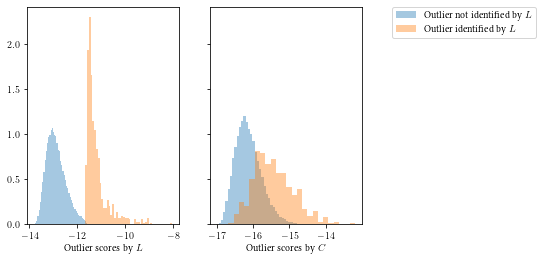

In [15]:
fig, axes = plt.subplots(1, 2, sharey=True)

result_local = np.reshape(result_local, newshape=(oldshape[0]*oldshape[1]))
result_global = np.reshape(result_global, newshape=(oldshape[0]*oldshape[1]))

ax = axes[0]
sns.distplot(result_local[np.invert(labels_local.flatten())], 
             hist=True, rug=False, kde=False, 
             rug_kws={"alpha": 0.3}, norm_hist=True, 
             ax=ax)

sns.distplot(result_local[labels_local.flatten()], 
             hist=True, rug=False, kde=False, 
             rug_kws={"alpha": 0.5}, norm_hist=True, 
             ax=ax)

# ax.set_xlim((0, 7))
ax.set_xlabel("Outlier scores by $L$")

ax = axes[1]

sns.distplot(result_global[np.invert(labels_local.flatten())], 
             hist=True, rug=False, kde=False, norm_hist=True, 
             rug_kws={"alpha": 0.3}, label="Outlier not identified by $L$", 
             ax=ax)

sns.distplot(result_global[labels_local.flatten()], 
             hist=True, rug=False, kde=False, 
             rug_kws={"alpha": 0.5}, norm_hist=True, 
             label="Outlier identified by $L$", 
             ax=ax)


# ax.set_xlim((0, 7))
plt.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)

ax.set_xlabel("Outlier scores by $C$")
# plt.tight_layout()

In [16]:
result_local = np.reshape(result_local, newshape=result_global.shape)

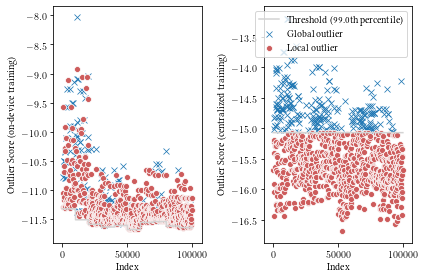

In [17]:
x = np.array([i for i in range(len(result_global))])

# labels_local and not labels_global
is_local_outlier = np.logical_and(labels_local, result_global < np.percentile(result_global, percentile))
is_global_outlier = np.logical_and(np.invert(is_local_outlier), labels_local)

plt.subplot(121)

sns.lineplot(x, outlier_thresh_local.flatten(), 
                 alpha=1, color="lightgrey")
sns.scatterplot(x[is_global_outlier], result_local[is_global_outlier], 
                alpha=1.0, marker="x")
sns.scatterplot(x[is_local_outlier], result_local[is_local_outlier], 
                color="indianred")

plt.xlabel("Index")
plt.ylabel("Outlier Score (on-device training)")

ax = plt.subplot(122)

sns.lineplot(x, outlier_thresh_global, 
                 alpha=1, color="lightgrey", label="Threshold ({}th percentile)".format(percentile))
sns.scatterplot(x[is_global_outlier], result_global[is_global_outlier], 
                alpha=1.0, marker="x", label="Global outlier")
sns.scatterplot(x[is_local_outlier], result_global[is_local_outlier], 
                color="indianred", alpha=1.0, label="Local outlier")

plt.legend(loc="upper right")
plt.xlabel("Index")
plt.ylabel("Outlier Score (centralized training)")

plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "figures", "results", "emotor_comparison_local_central_xstream.pdf"))
plt.show()